In [2]:
#handling all imports + collection of data
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import *
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

Number of replicas: 1


In [3]:
MONET_FILENAMES = tf.io.gfile.glob('/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec')
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob('/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec')
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [4]:
def tfrecord_to_image(record):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    
    record = tf.io.parse_single_example(record, tfrecord_format);
    image = record["image"]
    #decoding image from tensor to img
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 127.5 - 1 #normalizes tensor values from 0 -> 255 to -1 -> 1
    image = tf.reshape(image, [256, 256, 3]) #returns image shape to 256x256x3 (is the same shape for all images...)
    
    return image


def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames);
    dataset = dataset.map(tfrecord_to_image, num_parallel_calls = AUTOTUNE)
    return dataset

m_dataset = load_dataset(MONET_FILENAMES).batch(1)
p_dataset = load_dataset(PHOTO_FILENAMES).batch(1)

2023-01-02 16:58:29.129657: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Now that we have the tfrecords unpacked and processed into images, let's perform some visualization so we can understand exactly what data we have in both our Monet and Photo datasets.

2023-01-02 16:58:29.371368: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


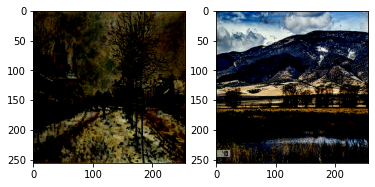

In [5]:
monet_img = next(iter(m_dataset))[0] #takes a batch of the dataset
photo_img = next(iter(p_dataset))[0] #takes a batch of the dataset

f, axarr = plt.subplots(1, 2)

axarr[0].imshow(monet_img)
axarr[1].imshow(photo_img)

# **BUILDING THE GAN**

First, a key part of the generator and discriminator models I intend on using is up/downsampling. While Keras has a Upsample layer within it, it's a basic, and for a lack of a better word, unintelligent approach for the upsample process. It only repeats column and row data, but we need a wiser approach to up and down sampling. This is where Conv2DTranspose comes into play. Utilizing it, we can use the following algorithms for up and down sampling.
<br><br>

- **Upsampling Algorithm**:
    - 2D Convolution Transpose with a fixed stride, specified filter and size, and randomly decided kernel initializer
    - Instance normalization with a randomly decided constraint for the gamma hyperparam
    - Conditional Dropout with a 50% dropout rate
    - Output is then applied to a ReLU activation function


- **Downsampling Algorithm**:
    - 2D Convolution with a fixed stride, specified filter and size, and randomly decided kernel initializer
    - Conditional Instance normalization with a randomly decided constraint for the gamma hyperparam
    - Output is then applied to a Leaky ReLU activation function

In [6]:

def upsample(filters, size, apply_dropout=False):
    init = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0., stddev=0.02)
    
    upsample_layers = [
        keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer = init, use_bias = False),
        tfa.layers.InstanceNormalization(gamma_initializer = gamma_init)
    ]
    
    if (apply_dropout == True):
        upsample_layers.append(keras.layers.Dropout(0.33))
    
    upsample_layers.append(keras.layers.ReLU())
    
    seq = keras.Sequential()
    
    for layer in upsample_layers:
        seq.add(layer)
    
    return seq


def downsample(filters, size, apply_norm=True):
    init = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0., stddev=0.02)
    
    seq = keras.Sequential()
    
    seq.add(
        keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer = init, use_bias = False)
    )
    
    if (apply_norm == True):
        seq.add(tfa.layers.InstanceNormalization(gamma_initializer = gamma_init))
    
    seq.add(keras.layers.LeakyReLU())

    return seq

**GENERATOR**
<br>
The architecture for the generator repeats downsampling - applying instance normalization (normalizing minibatches of data across each channel) for all but the first downsample - upon the input image (of shape 256x256x3), and establishes skip connections that are connected to the repeated stack of upsampling layers, which apply dropout for the first three layers. The generator then ends with one last Conv2DTranpose, which reshapes the input from 128x128x128 to the original input shape of 256x256x3. 
<br>
<br>
Sizes for each step are detailed in the code.

In [7]:
def build_generator():
    inputs = keras.layers.Input(shape = [256, 256, 3])
        
    down_layers = [
        downsample(64,4, apply_norm=False), # (bs, 128, 128, 64)
        downsample(128,4),                  # (bs, 64, 64, 128)
        downsample(256,4),                  # (bs, 32, 32, 256)
        downsample(512,4),                  # (bs, 16, 16, 512)
        downsample(512,4),                  # (bs, 8, 8, 512)
        downsample(512,4),                  # (bs, 4, 4, 512)
        downsample(512,4),                  # (bs, 2, 2, 512)
        downsample(512,4)                   # (bs, 1, 1, 512)
    ]
    
    up_layers = [
        upsample(512, 4, apply_dropout = True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout = True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout = True), # (bs, 8, 8, 1024)
        upsample(512, 4),                       # (bs, 16, 16, 1024)
        upsample(256, 4),                       # (bs, 32, 32, 512)
        upsample(128, 4),                       # (bs, 64, 64, 256)
        upsample(64, 4)                         # (bs, 128, 128, 128)
    ]
        
    output = inputs
    skips = []
    
    #applying downsampling to the inputs
    for d_layer in down_layers:
        output = d_layer(output)
        skips.append(output)
    
    #skip connections  
    skips = reversed(skips[:-1])
    
    init = tf.random_normal_initializer(0.,0.02)
    last = keras.layers.Conv2DTranspose(3, 4, strides = 2, padding = 'same', kernel_initializer = init, activation = 'tanh')
    
    for u_layer, skip in zip(up_layers, skips):
        output = u_layer(output)
        output = keras.layers.Concatenate()([output, skip])
    
    output = last(output)
    
    return keras.Model(inputs=inputs, outputs=output)

**DISCRIMINATOR**
<br>
The discriminator architecture starts with a 256x256x3 sized input, then downsampling several times (applies instance normalization the first time), then pads and convolves the data twice, with instance normalization and a leaky ReLU applied in between each pad + convolve.
<br>
<br>
Sizes for each step are detailed in the code.

In [8]:
def build_discriminator():
    init = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean = 0., stddev = 0.02)
    
    inputs = keras.layers.Input(shape = [256,256,3])
    
    layers = [
        downsample(64, 4, apply_norm=False),                                                 #(bs, 128, 128, 64)
        downsample(128, 4),                                                                  #(bs, 64, 64, 128) 
        downsample(128, 4),                                                                  #(bs, 32, 32, 128)
        keras.layers.ZeroPadding2D(),                                                        #(bs, 34, 34, 128)
        keras.layers.Conv2D(512, 4, strides=1, kernel_initializer = init, use_bias = False), #(bs, 31, 31, 512)
        tfa.layers.InstanceNormalization(gamma_initializer = gamma_init),                    #(bs, 31, 31, 512)
        keras.layers.LeakyReLU(),                                                            #(bs, 31, 31, 512)
        keras.layers.ZeroPadding2D(),                                                        #(bs, 33, 33, 512)
        keras.layers.Conv2D(1,4,strides=1, kernel_initializer = init)                        #(bs, 30, 30, 1)
    ]
    
    output = inputs
    
    for layer in layers:
        output = layer(output)
        
    return keras.Model(inputs = inputs, outputs = output)

In [9]:
m_gen = build_generator()
p_gen = build_generator()

m_disc = build_discriminator()
p_disc = build_discriminator()

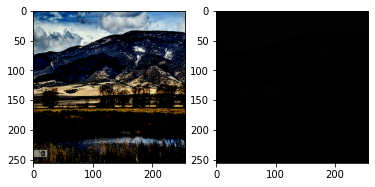

In [10]:
photo_img_reshaped = tf.reshape(photo_img, [1,256,256,3])
generated_monet = tf.reshape(m_gen(photo_img_reshaped), [256, 256, 3])

f, axarr = plt.subplots(1, 2)

axarr[0].imshow(photo_img)
axarr[1].imshow(generated_monet)

**TRAINING THE CYCLEGAN**

With our modified CycleGAN architecture, we are now ready to train the model.
<br>
<br>
First, we must establish the loss functions we intend on evaluating the model with.
- To calculate the generator and discriminator loss, we can use Binary Crossentropy/Log loss:
  https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a
- For the generator loss, the loss function is directly applying BCE on the generated image. The generator attempts to maximize this loss to maximize the discriminator's output for fake instances. 
- For the discriminator loss, the loss function is applying BCE on the real and generated image seperately, and dividing it by 2. The discriminator attempts to maximize its loss to find all generated pieces of data. 

- To calculate the cycle loss, we compare the real image, with the generator's cycled versions of the images. The purpose of the cycle loss is to allow for comparison aka training to be performed without paired data - it eliminates the need for one-on-one mapping of data between the source and target domains. We calculate the total cycle loss by summing the cycle loss of the photo and Monet cycle loss.
   - The following is a visual interpretation of the cycle consistency loss:
   
   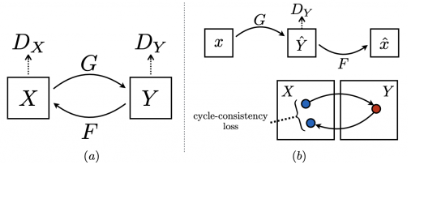

- The identity loss takes the generator's interpretation of the self pertaining data and compares it to the real initial data. In doing so, it helps regularize the generator to be near an identity mapping when real samples of the target domain are provided, and discourages the generator from translating the image if it's within a similar domain of the original image.
- We will resort to Adam optimizers for this GAN. **(further experimentation w/ ideal optimizer is needed)**

- The following is the final generator loss:

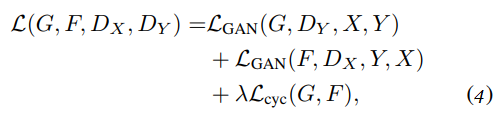

- It is calculated by summing the generator loss with the cycle loss and the identity loss.
- We can do this for both the Monet and Photo generators that we have created.
<br><br>
- After all of the losses have been calculated, the gradients for the total generator losses and discriminator losses are calculated and applied to the respective optimizers. This cycle continues for the specified number of epochs.

In [11]:
class CycleGAN(keras.Model):
    def __init__(self, m_gen, p_gen, m_disc, p_disc, l_cycle = 10):
        super(CycleGAN, self).__init__()
        self.m_gen = m_gen
        self.p_gen = p_gen
        self.m_disc = m_disc
        self.p_disc = p_disc
        self.l_cycle = l_cycle
    
    def compile(self, m_gen_opt, p_gen_opt, m_disc_opt, p_disc_opt, gen_loss, disc_loss, cycle_loss, identity_loss):
        super(CycleGAN, self).compile()
        self.m_gen_opt = m_gen_opt
        self.p_gen_opt = p_gen_opt
        self.m_disc_opt = m_disc_opt
        self.p_disc_opt = p_disc_opt
        self.gen_loss = gen_loss
        self.disc_loss = disc_loss
        self.cycle_loss = cycle_loss
        self.identity_loss = identity_loss
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            
            #cycle loss eval stats
            fake_monet = self.m_gen(real_photo, training = True)
            fake_photo = self.p_gen(real_monet, training = True)
            
            cycled_monet = self.m_gen(fake_photo, training = True) # <-- cycled monet image
            cycled_photo = self.p_gen(fake_monet, training = True) # <-- cycled photo image
            
            #identity loss eval stats
            self_gen_monet = self.m_gen(real_monet, training = True) #generating the monet image again using itself
            self_gen_photo = self.p_gen(real_photo, training = True) #generating the photo image again using itself
            
            #discriminator real outputs vs fake outputs - to be compared w/ disc_loss
            disc_real_monet = self.m_disc(real_monet, training = True)
            disc_real_photo = self.p_disc(real_photo, training = True)
            
            disc_fake_monet = self.m_disc(fake_monet, training = True)
            disc_fake_photo = self.p_disc(fake_photo, training = True)
            
            #generator loss functions
            monet_gen_loss = self.gen_loss(disc_fake_monet)
            photo_gen_loss = self.gen_loss(disc_fake_photo)
            
            #total cycle consistency loss
            total_cycle_loss = self.cycle_loss(real_monet, cycled_monet, self.l_cycle) + self.cycle_loss(real_photo, cycled_photo, self.l_cycle)
            
            #total generator loss functions
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss(real_monet, self_gen_monet, self.l_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss(real_photo, self_gen_photo, self.l_cycle)
            
            #discriminator loss functions
            monet_disc_loss = self.disc_loss(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss(disc_real_photo, disc_fake_photo)
            
            #calculating generator gradients
            monet_gen_grads = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
            photo_gen_grads = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
            
            #calculating discriminator gradients
            monet_disc_grads = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
            photo_disc_grads = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)
            
            #applying monet generator and discriminator gradients 
            self.m_gen_opt.apply_gradients(zip(monet_gen_grads, self.m_gen.trainable_variables))
            self.m_disc_opt.apply_gradients(zip(monet_disc_grads, self.m_disc.trainable_variables))
            
            #applying photo generator and discriminator gradients
            self.p_gen_opt.apply_gradients(zip(photo_gen_grads, self.p_gen.trainable_variables))
            self.p_disc_opt.apply_gradients(zip(photo_disc_grads, self.p_disc.trainable_variables))
            
            #returning bundled generator and discriminator losses
            return {
                "monet_gen_loss" : total_monet_gen_loss,
                "photo_gen_loss" : total_photo_gen_loss,
                "monet_disc_loss" : monet_disc_loss,
                "photo_disc_loss" : photo_disc_loss
            }

In [12]:
with strategy.scope():
    def disc_loss(real, gen):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        gen_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(gen), gen)

        return (real_loss + gen_loss)/2

    def gen_loss(gen):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(gen), gen)
    
    def cycle_loss(real, cycled, l):
        return l * tf.reduce_mean(tf.abs(real-cycled))
    
    def identity_loss(real, self_gen, l):
        return l * tf.reduce_mean(tf.abs(real - self_gen)) / 2
    
    m_gen_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    p_gen_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    m_disc_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    p_disc_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    
    model = CycleGAN(m_gen, p_gen, m_disc, p_disc)
    model.compile(m_gen_opt, p_gen_opt, m_disc_opt, p_disc_opt, gen_loss, disc_loss, cycle_loss, identity_loss)

In [ ]:
model.fit(tf.data.Dataset.zip((m_dataset, p_dataset)), epochs=30)

Epoch 1/30
300/300 [==============================] - 1686s 5s/step - monet_gen_loss: 5.2917 - photo_gen_loss: 5.4940 - monet_disc_loss: 0.6537 - photo_disc_loss: 0.6069
Epoch 2/30
300/300 [==============================] - 1623s 5s/step - monet_gen_loss: 3.6030 - photo_gen_loss: 3.7725 - monet_disc_loss: 0.6809 - photo_disc_loss: 0.6280
Epoch 3/30
300/300 [==============================] - 1629s 5s/step - monet_gen_loss: 3.4662 - photo_gen_loss: 3.6540 - monet_disc_loss: 0.6585 - photo_disc_loss: 0.6071
Epoch 4/30
300/300 [==============================] - 1626s 5s/step - monet_gen_loss: 3.3738 - photo_gen_loss: 3.5714 - monet_disc_loss: 0.6497 - photo_disc_loss: 0.5910
Epoch 5/30
300/300 [==============================] - 1625s 5s/step - monet_gen_loss: 3.2406 - photo_gen_loss: 3.3942 - monet_disc_loss: 0.6347 - photo_disc_loss: 0.6010
Epoch 6/30
300/300 [==============================] - 1628s 5s/step - monet_gen_loss: 3.1836 - photo_gen_loss: 3.3510 - monet_disc_loss: 0.6214 - phot

In [ ]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(p_dataset.take(5)):
    pred = m_gen(img, training=False)[0].numpy() #prediction is scaled from -1 -> 1
    pred = (pred * 127.5 + 127.5).astype(np.uint8) #this makes it scaled back to 0 -> 255
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8) 

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(pred)
    ax[i, 0].set_title("Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [ ]:
import PIL
import shutil
os.mkdir("/kaggle/working/images")
print("OUTPUT DIRECTORY CREATED")

for img in photo_ds:
    pred = m_gen(img, training=False)[0].numpy()
    pred = (pred * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("/kaggle/working/images/" + str(i) + ".jpg")
    
shutil.make_archive("/kaggle/working/images", "zip", "/kaggle/images")

And with that, we are done! <br>
Thank you for checking out my code on this Kaggle competition. Have a great day :)